<a href="https://colab.research.google.com/github/gnapat/CNN_Imageclassified/blob/Imbalanced-4/hw01_allone_thaifood10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import InceptionResNetV2
#from tf.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import VGG19

import cv2 as cv
import pandas as pd

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]

NumPy 1.23.5

Matplotlib 3.7.1

TensorFlow 2.14.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset preparing

In [4]:
#!ls -lrt /kaggle/input/top-10-best-rated-thai-food/top10_thai_food_dataset/
#!ls top10_thai_food_dataset/

!cp drive/MyDrive/Gz/nida/dl/hw01/THFOOD50-v1.zip ./
!unzip THFOOD50-v1.zip

#!cp drive/MyDrive/Gz/nida/dl/hw01/top10_thai_food_dataset.zip ./
#!unzip top10_thai_food_dataset.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
 extracting: THFOOD50-v1/train/PadPakRuamMit/057.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/058.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/059.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/060.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/061.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/062.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/064.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/065.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/066.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/067.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/068.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/069.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/070.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/071.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/072.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/073.jpg  
  inflating: THFOOD50-v1/train/PadPakRuamMit/074.jpg  
  inflat

In [5]:
def to_array(X):
  images=[]
  for x in X:
    img_array = tf.keras.preprocessing.image.img_to_array(x).astype(np.uint8)
    images.append(img_array)

  X_ret = np.array(images)

  return X_ret




def do_augmentation(img,y,aug):

  ret_x=[]
  ret_y=[]

  if aug == 1:
    aug_list = [Image.FLIP_LEFT_RIGHT]
  elif aug == 2:
    aug_list = [Image.ROTATE_180]
  elif aug == 3:
    #aug_list = [Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270]
    aug_list = [Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90]
  elif aug == 4:
    #aug_list = [Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270,Image.FLIP_LEFT_RIGHT,Image.ROTATE_90,Image.ROTATE_180,Image.ROTATE_270]
    aug_list = [Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90,Image.FLIP_LEFT_RIGHT,Image.ROTATE_90,Image.ROTATE_90,Image.ROTATE_90]



  ret_x.append(img)
  ret_y.append(y)

  #img = tf.keras.utils.array_to_img(img)

  for iaug in aug_list:
    img = img.transpose(method=iaug)
    #img_arr = tf.keras.preprocessing.image.img_to_array(img)
    ret_x.append(img)
    ret_y.append(y)



  return ret_x,ret_y

def load_dataset(xlist,ylist,aug=0):

  images = []
  labels = []

  cc = 0
  for f in xlist:
    img = tf.keras.preprocessing.image.load_img(f, target_size=(224, 224))

    if aug != 0:
      # do aug
      img_aug , y_aug = do_augmentation(img=img,y=ylist[cc],aug=aug)

      images.extend(img_aug)
      labels.extend(y_aug)
      #pass

    else:
      #img = tf.keras.preprocessing.image.img_to_array(img)
      img = tf.keras.preprocessing.image.img_to_array(img)
      images.append(img)
      labels.append(ylist[cc])

    cc += 1

  return images,labels




def prepare_dataset(path,lables,test_size=0.2, random_state=42,split=True,augmentation=0,do_img_array=0):

  x = []
  y=[]
  x_path=[]
  images = []
  X_train = np.empty((244,244,3))
  X_test = np.array([])
  y_train = np.empty( (244,244,3))
  y_test =np.array([])

  for i in rock_label:
    folder_path=f"{path}/{rock_label[i]}"
    print(folder_path)
    files = os.listdir(folder_path)
    for file in files:
      target_path = f"{folder_path}/{file}"
      #print(target_path)
      #img =  tf.keras.preprocessing.image.load_img(target_path, target_size=(224, 224))
      #img = tf.keras.preprocessing.image.img_to_array(img)
      #images.append(img)

      x_path.append(target_path)
      y.append(int(i))

  if split == True:
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(x_path, y, test_size=0.3, random_state=42)
    #print(type(X_train_temp))
    X_train_temp, y_train_temp = load_dataset(X_train_temp,y_train_temp,augmentation)
    #print(type(X_train_temp))
    X_test_temp, y_test_temp = load_dataset(X_test_temp,y_test_temp,augmentation)

  if split == True:
    if do_img_array == 0:
      # return with image format
      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
    else:
      # return with nunpy array
      X_train_temp = to_array(X_train_temp)
      X_test_temp = to_array(X_test_temp)
      y_train_temp = np.array(y_train_temp)
      y_test_temp = np.array(y_test_temp)

      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
  else:
    return X,Y

def get_label_from_dataset(path):
  label_dict={}
  files = os.listdir(f"{path}/train")
  cc = 0
  for file in files:
        #print(file)
        key=f"{cc}"
        label_dict[cc] = file
        if cc >=4:
          break
        cc += 1

  #print(label_dict)
  return(label_dict)


def prepare_dataset_top10(path,lables,test_size=0.2, random_state=42,split=True,augmentation=0,do_img_array=0):

  x = []
  y=[]
  x_path=[]
  images = []
  X_train = np.empty((244,244,3))
  X_test = np.array([])
  y_train = np.empty( (244,244,3))
  y_test =np.array([])

  for j in ['train','test']:

    for i in lables:
      folder_path=f"{path}/{j}/{lables[i]}"
      print(folder_path)
      files = os.listdir(folder_path)
      for file in files:
        target_path = f"{folder_path}/{file}"
        #print(target_path)
        #img =  tf.keras.preprocessing.image.load_img(target_path, target_size=(224, 224))
        #img = tf.keras.preprocessing.image.img_to_array(img)
        #images.append(img)

        x_path.append(target_path)
        y.append(int(i))

  if split == True:
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(x_path, y, test_size=0.3, random_state=42)
    #print(type(X_train_temp))
    X_train_temp, y_train_temp = load_dataset(X_train_temp,y_train_temp,augmentation)
    #print(type(X_train_temp))
    X_test_temp, y_test_temp = load_dataset(X_test_temp,y_test_temp,augmentation)

  if split == True:
    if do_img_array == 0:
      # return with image format
      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
    else:
      # return with nunpy array
      X_train_temp = to_array(X_train_temp)
      X_test_temp = to_array(X_test_temp)
      y_train_temp = np.array(y_train_temp)
      y_test_temp = np.array(y_test_temp)

      return X_train_temp, X_test_temp, y_train_temp, y_test_temp
  else:
    return X,Y

def show_dataset_distribution(path,labels):
  ret_list = {}
  for label in labels:
    #print(labels[label])
    cc = 0
    dirs = os.listdir(f"{path}/{labels[label]}")
    for dir in dirs:
      #print(f"{path}/{dir}")
      files = os.listdir(f"{path}/{labels[label]}/")

      for file in files:
        #print(f"{path}/{dir}/{file}")
        cc += 1
    ret_list[labels[label]] = cc
    #print(f"{labels[label]} = {cc}")

  return(ret_list)



{'Phanaeng_Curry': 44100, 'Green_Curry': 44100, 'Pad_Thai': 35721, 'Khao_soi': 44100, 'Roti_canai': 21025}


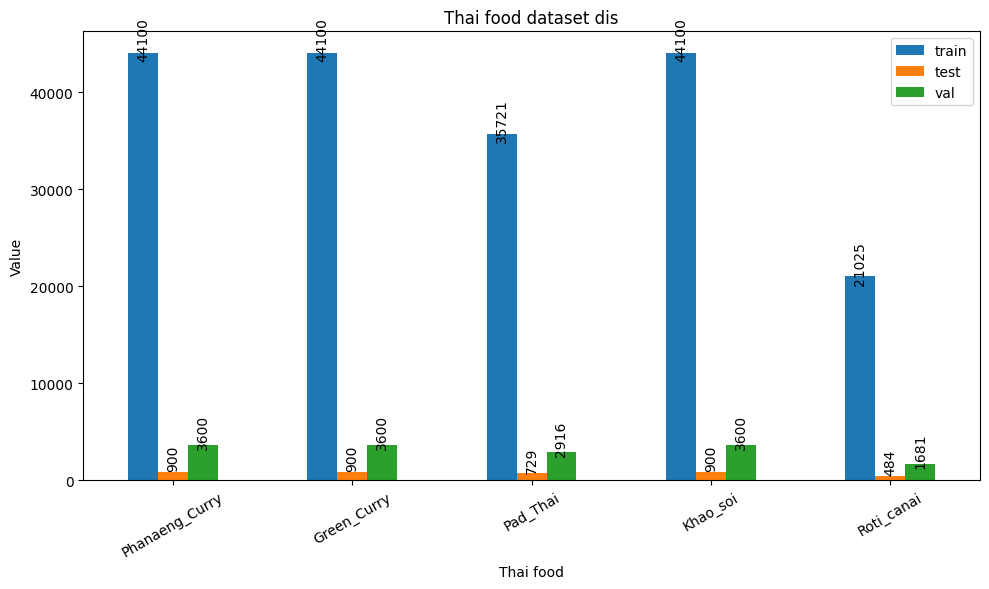

In [5]:
path="top10_thai_food_dataset"
rock_label={"0":"Joke","1":"KaiThoon","2":"KaiJeowMooSaap","3":"KaoManGai"}
#print(type(rock_label))
Glabel = get_label_from_dataset(path)
#print(Glabel)
ppath=f"{path}/train"
result_train = show_dataset_distribution(ppath,Glabel)
ppath=f"{path}/test"
result_test = show_dataset_distribution(ppath,Glabel)
ppath=f"{path}/val"
result_val = show_dataset_distribution(ppath,Glabel)
print(result_train)

df_train = pd.DataFrame.from_dict(result_train, orient ='index').reset_index()
df = df_train.rename(columns={0: 'train'})

df_test = pd.DataFrame.from_dict(result_test, orient ='index').reset_index()
df_test = df_test.rename(columns={0: 'test'})
df['test'] = df_test['test']

df_val = pd.DataFrame.from_dict(result_val, orient ='index').reset_index()
df_val = df_val.rename(columns={0: 'val'})
df['val'] = df_val['val']

df.set_index('index', inplace=True)
ax  = df.plot(kind='bar', figsize=(10, 6))

plt.title('Thai food dataset dis')
plt.xlabel('Thai food')
plt.ylabel('Value')
plt.xticks(rotation=30)  # Rotate category labels (if needed)
plt.tight_layout()  # Fit the plot within the figure neatly

for idx, p in enumerate(ax.patches):
    # The annotation position
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points',rotation=90)

plt.tight_layout()

# Display the plot
plt.show()

#X_train,X_test,Y_train,Y_test = prepare_dataset_top10(path=path,lables=Glabel,split=True,augmentation=3,do_img_array=1)


In [7]:
path="THFOOD50-v1/train"
X_train,X_test,Y_train,Y_test = prepare_dataset(path=path,lables=Glabel,split=True,augmentation=3,do_img_array=1)

NameError: ignored

In [7]:
#base_architecture = {"VGG16": VGG16(weights="imagenet", include_top=True),
#                     "ResNet50":ResNet50(weights='imagenet', include_top=True),
#                     "MobileNet":MobileNet(weights='imagenet', include_top=True)}
images_size = 224
img_w=224
img_h=224
batch_size = 64

base_architecture = {"ResNet50V2":ResNet50V2(input_shape = (img_w, img_h, 3), weights='imagenet', include_top=True),
                      "ResNet152V2":ResNet152V2(input_shape = (img_w, img_h, 3), weights='imagenet', include_top=True),
                      "MobileNetV2":MobileNetV2(input_shape = (img_w, img_h, 3), weights='imagenet', include_top=True),
                      "VGG19":VGG19(input_shape = (img_w, img_h, 3), weights='imagenet', include_top=True)}

processing= {"ResNet50V2":tf.keras.applications.mobilenet,
              "ResNet152V2":tf.keras.applications.mobilenet,
              "MobileNetV2":tf.keras.applications.mobilenet,
              "VGG19":tf.keras.applications.vgg19}

base_architecture_list = ["ResNet50V2","ResNet152V2","MobileNetV2","VGG19"]


574710816/574710816 [==============================] - 26s 0us/step


In [8]:
def do_predic(aname,x):

  model = base_architecture[aname]
  x_train_preprocess = processing[aname].preprocess_input(x)
  img_preprocess1 = np.expand_dims(x_train_preprocess,axis=0)
  pred = model.predict(img_preprocess1)

  return(pred)

def imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    Our adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        result.sort(key=lambda x: x[-1], reverse=True)
        results.append(result)

    return CLASS_INDEX, results

In [9]:

def show_prediction_by_pic(input):
  list_pred=[]
  list_result=[]
  M = len(base_architecture_list)
  print(M)
  fig, ax = plt.subplots(1, M+1, figsize=(30, 5))

  ax[0].imshow(tf.keras.preprocessing.image.array_to_img(input))
  ax[0].set_title('Plot')
  c=1
  print(type(processing))
  for m in base_architecture_list:
    print(m)
    model = base_architecture[m]
    print(processing[m])
    x_preprocess = processing[m].preprocess_input(input)
    #x_test_preprocess = processing[m].preprocess_input(X_test)

    img_preprocess1 = np.expand_dims(x_preprocess,axis=0)
    pred = model.predict(img_preprocess1)
    print(pred.shape)
    list_pred.append(pred)
    imagenet_dict, result1  = imagenet_decode_predictions(pred)
    list_result.append(result1)

    df = pd.DataFrame(result1[0], columns=['Index', 'ID', 'Description', 'Score'])
    title=f"model {base_architecture_list[c-1]}"
    ax[c].set_title(title)
    table = ax[c].table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')
    table.scale(1, 4)
    c += 1
  plt.show()



4
<class 'dict'>
ResNet50V2
<module 'keras.api._v2.keras.applications.mobilenet' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/applications/mobilenet/__init__.py'>
1/1 [==============================] - 8s 8s/step
(1, 1000)
35363/35363 [==============================] - 0s 0us/step
ResNet152V2
<module 'keras.api._v2.keras.applications.mobilenet' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/applications/mobilenet/__init__.py'>
1/1 [==============================] - 2s 2s/step
(1, 1000)
MobileNetV2
<module 'keras.api._v2.keras.applications.mobilenet' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/applications/mobilenet/__init__.py'>
1/1 [==============================] - 1s 1s/step
(1, 1000)
VGG19
<module 'tensorflow.keras.applications.vgg19' from '/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/applications/vgg19/__init__.py'>
1/1 [==============================] - 1s 1s/step
(1, 1000)


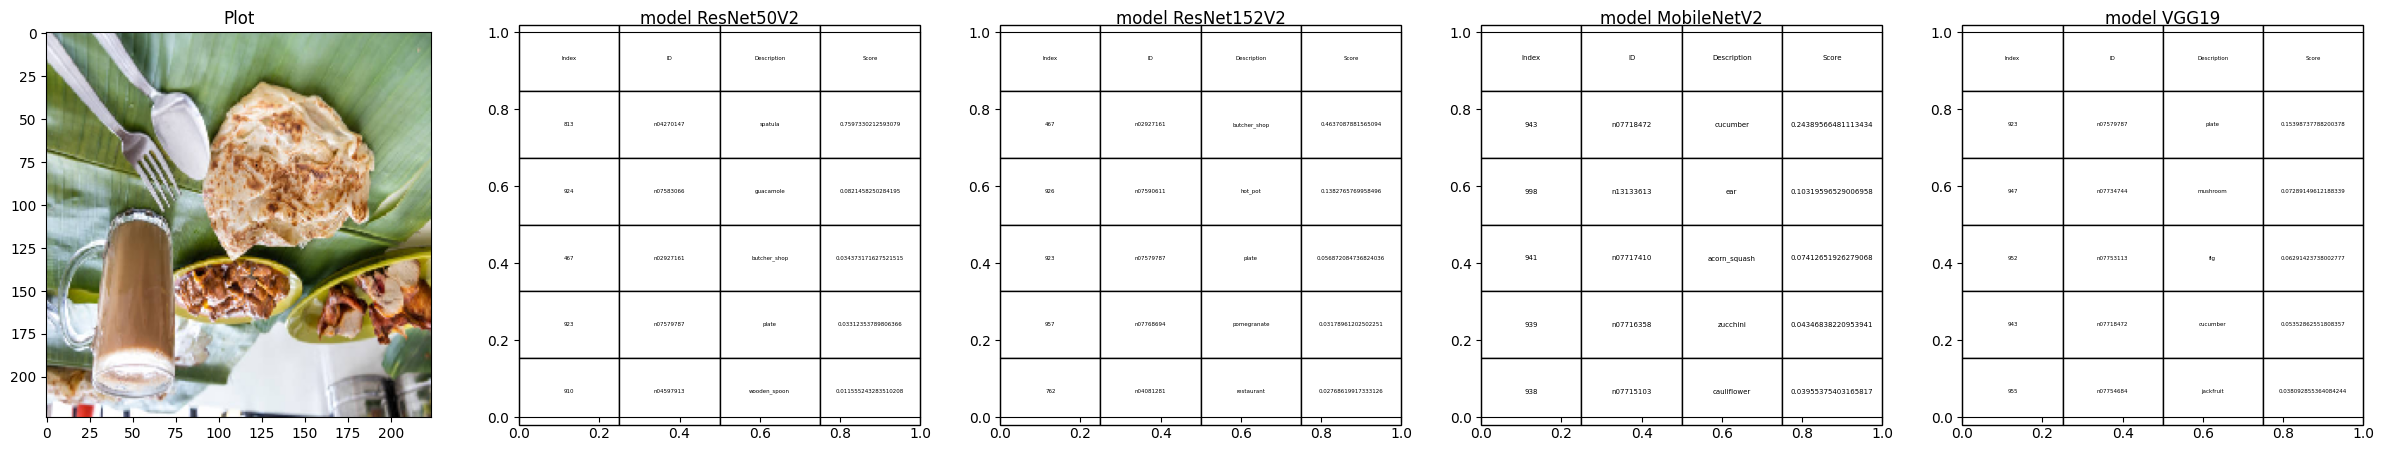

In [10]:
import pandas as pd

show_prediction_by_pic(X_train[2])

In [11]:
img_w,img_h = 224,224
#my_architecture = {"VGG16": VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3)),
#                     "ResNet50":ResNet50(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3)),
#                     "MobileNet":MobileNet(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))}

my_architecture = {"ResNet50V2":ResNet50V2(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3)),
                      "ResNet152V2":ResNet152V2(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3)),
                      "MobileNetV2":MobileNetV2(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3)),
                      "VGG19":VGG19(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))}
my_model=[]
for m in base_architecture_list:
  my_architecture[m].trainable = False

  x = my_architecture[m].output
  # Add our custom layer(s) to the end of the existing model
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

  # Construct the main model
  model = tf.keras.models.Model(inputs=my_architecture[m].inputs, outputs=new_outputs)
  model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

  my_model.append(model)




80134624/80134624 [==============================] - 4s 0us/step


In [12]:
all_history=[]
cc = 0
#base_architecture_list = ["ResNet50V2","ResNet152V2","MobileNetV2","VGG19"]
for m in base_architecture_list:
  x_train_ = processing[m].preprocess_input(X_train)
  x_test_ = processing[m].preprocess_input(X_test)
  history = my_model[cc].fit( x_train_, Y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2 )
  cc += 1

  all_history.append(history)

Epoch 1/20
20/20 [==============================] - 23s 759ms/step - loss: nan - acc: 0.2206 - val_loss: nan - val_acc: 0.2071
Epoch 2/20
20/20 [==============================] - 8s 419ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 3/20
20/20 [==============================] - 8s 422ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 4/20
20/20 [==============================] - 8s 426ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 5/20
20/20 [==============================] - 9s 432ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 6/20
20/20 [==============================] - 9s 437ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 7/20
20/20 [==============================] - 9s 438ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc: 0.2071
Epoch 8/20
20/20 [==============================] - 9s 447ms/step - loss: nan - acc: 0.2235 - val_loss: nan - val_acc

KeyboardInterrupt: ignored

In [ ]:
cc = 0
for m in base_architecture_list:
  x_train_ = processing[m].preprocess_input(X_train)
  x_test_ = processing[m].preprocess_input(X_test)
  history = my_model[cc].evaluate(x_test_, Y_test, batch_size=128)
  cc += 1

In [ ]:
all_history[0]

plt.figure(figsize=(15,5))
#plt.plot(all_history[0].history['acc'])
plt.plot(all_history[0].history['val_acc'])
plt.plot(all_history[1].history['val_acc'])
plt.plot(all_history[2].history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([base_architecture_list[0], base_architecture_list[1], base_architecture_list[2]], loc='lower right')
plt.grid()
plt.show()

In [ ]:
from datetime import datetime
cc=0
for m in base_architecture_list:

  current_datetime = datetime.now()
  datetime_string = current_datetime.strftime('%Y%m%d_%H%M%S')
  fn = f"{m}_{datetime_string}.h5"
  my_model[cc].save(fn)
  cc += 1

In [ ]:
!echo $datetime_string
!mkdir drive/MyDrive/Gz/nida/dl/hw01/$datetime_string
!cp *.h5 drive/MyDrive/Gz/nida/dl/hw01/$datetime_string/

In [ ]:
def mo_imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    Our adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    if len(preds.shape) != 2 or preds.shape[1] != 4:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        #top_indices


        #result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        for i in top_indices:
          if i < len(rock_label):
            #print(l)
            #print(CLASS_INDEX[i])
            result =  [(i,) + tuple([rock_label[str(i)]]) + (pred[i],)]
            result.sort(key=lambda x: x[-1], reverse=True)
            results.append(result)

    return CLASS_INDEX, results

In [ ]:
plt.imshow(tf.keras.preprocessing.image.array_to_img(X_test[599])); plt.show()
img_preprocess1 = np.expand_dims(x_test_[599],axis=0)
pred = model.predict(img_preprocess1)
his,result = mo_imagenet_decode_predictions(pred)
result

In [ ]:
img_preprocess1 = np.expand_dims(x_test_[498],axis=0)
pred = model.predict(img_preprocess1)

In [ ]:
his,result = mo_imagenet_decode_predictions(pred)
result